# General Configuration
### Imports all the necessary libraries

In [80]:
%pip install --upgrade pip
%pip install quantstats
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [81]:
import os
import pandas as pd
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import quantstats as qs

## Data management

In [82]:
def load_csv_files(num_weeks, data_folder='../data/ethereum-tokens', inclusion = 1):
    
    # List all files in the directory
    files = os.listdir(data_folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    
    # Extract dates from file names and pair them with file names
    files_with_dates = []
    for file in files:
        date_str = file.replace('.csv', '')
        date = datetime.strptime(date_str, '%Y-%m-%d')
        files_with_dates.append((file, date))
    
    # Sort files by date
    sorted_files_with_dates = sorted(files_with_dates, key=itemgetter(1))
    
    # Select every Nth file based on the num_weeks
    selected_files = [file for i, (file, date) in enumerate(sorted_files_with_dates) if i % num_weeks == 0]
    
    # Load selected files
    dfs = []
    token_presence_count = {}
    
    for file in selected_files:
        df = pd.read_csv(os.path.join(data_folder, file), index_col='Rank')
        
        # Count the presence of each token in the top tokens list
        tokens_to_remove = []

        for token_id in df['id']:
            token_presence_count[token_id] = token_presence_count.get(token_id, 0) + 1

        if len(dfs) > 2*inclusion:  # start checking from the n+1th week onwards
            for token_id in df['id']:
                if token_id in token_presence_count:
                    if token_presence_count[token_id] < inclusion:
                        tokens_to_remove.append(token_id)
                else:
                    tokens_to_remove.append(token_id)

        df = df[~df['id'].isin(tokens_to_remove)]
        
        dfs.append(df)

    return dfs

## Helper functions for calculate_index

In [83]:
def compute_divisor(snapshot, target_price=None):
    total_market_cap_0 = snapshot['Market cap'].sum()

    return total_market_cap_0 / target_price

def compute_current_value(snapshot, divisor):
    if divisor == 0:
        return None
    daily_value = snapshot['Market cap'].sum()
    index_value_t = daily_value / divisor
    return index_value_t

In [84]:
def compute_index_history(constituent_number, weeks_interval, initial_index_value = 100, swap_fees = 0, inc = 1):

    source_dfs = load_csv_files(weeks_interval, inclusion = inc)

    folder = f"../data/{weeks_interval}w-ethereum-tokens"

    files = os.listdir(folder)
    
    # Filter out files that are not CSV
    files = [f for f in files if f.endswith('.csv')]
    files = sorted(files)

    shifted_dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(folder, file), index_col='Rank')
        shifted_dfs.append(df)
    
    index_values = [initial_index_value]

    index_value = initial_index_value

    # print(source_dfs)
    # print(shifted_dfs)
    
    # Loop over all the data for backtesting
    for i in range(len(source_dfs)):
        source_df = source_dfs[i][:constituent_number]

        selected_tokens = set(source_df['id'])  # Get the tokens chosen in the source_df

        divisor = compute_divisor(source_df, index_value)
        # print(len(source_df))

        # Get data for all weeks between the rebalancing periods.
        for j in range(weeks_interval):
            if i*weeks_interval+j >= len(shifted_dfs):
                break

            shifted_df = shifted_dfs[i*weeks_interval+j][:constituent_number]

            # Filter the shifted_df to consider only the selected tokens
            shifted_df = shifted_df[shifted_df['id'].isin(selected_tokens)][:constituent_number]
            
            index_value = compute_current_value(shifted_df, divisor)
            if(j == weeks_interval-1):
                index_value -= swap_fees * constituent_number
            index_values.append(index_value)
            
    return index_values[:-1]


### Main calculate_index function

In [85]:
backtest = []

weeks = [1, 2, 4, 8, 12, 24]
constituents = [5, 10, 20, 30]

initial_value = 100
swap_fees = 0
inclusion_weeks = 0

for week in weeks:
    for constituent in constituents:
        backtest.append((compute_index_history(constituent, week, initial_value, swap_fees, inclusion_weeks), week, constituent))

backtest.sort(key=lambda x: x[0][-1], reverse=True)

## Performance analysis

In [ ]:
risk_free_rate = 0.5
print(f"Risk-free rate: {risk_free_rate}")

In [86]:
values, week, constituent = top_backtests[0]

prices_series = pd.Series(values, name=f'Weeks: {week}, Constituents: {constituent}')

returns = prices_series.pct_change().dropna()

dates = pd.date_range(start='1/12/2020', periods=len(prices_series)-1, freq='W')

returns.index = dates

start_date = dates[0].strftime('%Y-%m-%d')
end_date = dates[-1].strftime('%Y-%m-%d')

print(f"Start date: {start_date}, End date: {end_date}")


Risk-free rate: 0.5
Start date: 2020-01-12, End date: 2023-09-03


In [87]:
import pandas as pd
import quantstats as qs

# Creating an empty DataFrame to store the results
summary_stats = pd.DataFrame(columns=['Rank', 'Weeks', 'Constituents', 'Total Return', 'Mean Return', 'Median Return', 'Standard Deviation', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown'])

# Iterating through all the backtests to calculate the required statistics
for values, week, constituents in backtest:
    prices_series = pd.Series(values)
    returns = prices_series.pct_change().dropna()

    # Calculating the metrics
    total_return = (prices_series.iloc[-1] / prices_series.iloc[0] - 1) * 100
    mean_return = returns.mean() * 100
    median_return = returns.median() * 100
    std_dev = returns.std() * 100
    sharpe_ratio = qs.stats.sharpe(returns, rf=risk_free_rate)
    sortino_ratio = qs.stats.sortino(returns, rf=risk_free_rate)
    max_drawdown = qs.stats.max_drawdown(returns) * 100

    # Adding the results to the DataFrame
    summary_stats.loc[len(summary_stats)] = [0, week, constituents, round(total_return, 2), round(mean_return, 2), round(median_return, 2), round(std_dev, 2), round(sharpe_ratio, 2), round(sortino_ratio, 2), round(max_drawdown, 2)]

# Assigning ranks based on Total Return
summary_stats['Rank'] = summary_stats['Total Return'].rank(ascending=False).astype(int)

# Converting 'Weeks' and 'Constituents' to integers
summary_stats['Weeks'] = summary_stats['Weeks'].astype(int)
summary_stats['Constituents'] = summary_stats['Constituents'].astype(int)

# Exporting the DataFrame to a CSV file
csv_file_path = '../results/summary_stats.csv'
summary_stats.to_csv(csv_file_path, index=False)

# Displaying the DataFrame
print(summary_stats)


    Rank  Weeks  Constituents  Total Return  Mean Return  Median Return  \
0      1      1            30        621.47         2.02           1.62   
1      2      1             5        611.25         2.21           1.90   
2      3      2            30        555.85         1.96           1.62   
3      4      1            20        541.81         1.97           1.40   
4      5      8            30        520.60         1.93           1.67   
5      6      4            30        489.68         1.91           1.62   
6      7      2             5        478.21         2.10           1.90   
7      8      2            20        450.40         1.88           1.46   
8      9      4            20        403.20         1.83           1.46   
9     10      8             5        401.35         1.96           1.16   
10    11      4             5        378.79         1.95           1.90   
11    12      1            10        344.66         1.83           1.47   
12    13      8          

Legend:
Week 1, Constituents: 30, Color: Green (#008000)
Week 1, Constituents: 5, Color: Orange (#FFA500)
Week 2, Constituents: 30, Color: Blue (#0000FF)
Week 1, Constituents: 20, Color: Red (#FF0000)
Week 8, Constituents: 30, Color: Purple (#800080)


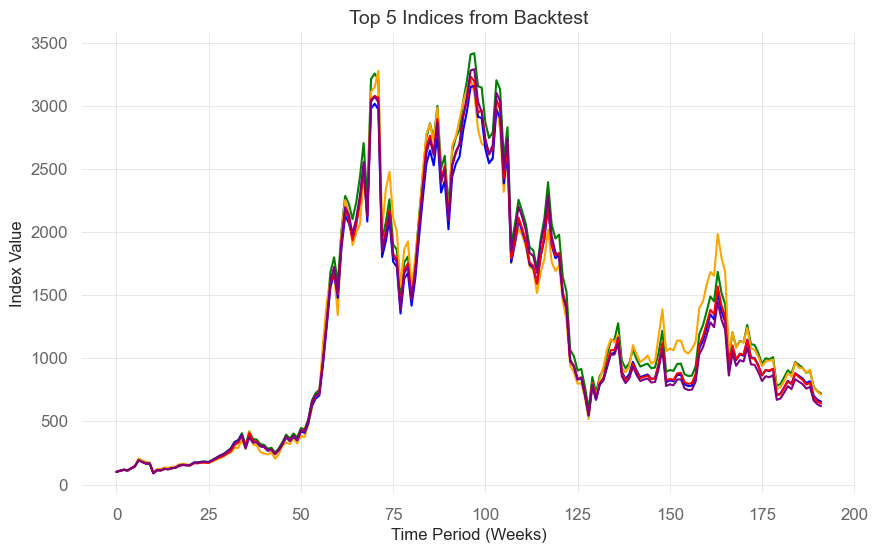

In [88]:
top_backtests = backtest[:5]  # Get the top 5 backtests

colors = [
    ("Green", '#008000'), 
    ("Orange", '#FFA500'), 
    ("Blue", '#0000FF'), 
    ("Red", '#FF0000'), 
    ("Purple", '#800080')
]

plt.figure(figsize=(10, 6))

print("Legend:")
for i, (values, week, constituents) in enumerate(top_backtests):
    plt.plot(values, color=colors[i][1])
    print(f"Week {week}, Constituents: {constituents}, Color: {colors[i][0]} ({colors[i][1]})")

plt.xlabel('Time Period (Weeks)', fontsize=12)
plt.ylabel('Index Value', fontsize=12)
plt.title('Top 5 Indices from Backtest', fontsize=14)
plt.grid(True)

# Save the plot as a high-resolution PNG file
plt.savefig('../results/top_5_indices_backtest.png', dpi=300)

plt.show()

In [89]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming 'Total Return' is one of the performance metrics in summary_stats
# 'Weeks' and 'Constituents' are the configurations you're testing

anova_model = ols('summary_stats["Total Return"] ~ C(summary_stats["Weeks"]) + C(summary_stats["Constituents"])', data=summary_stats).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)


                                         sum_sq    df          F        PR(>F)
C(summary_stats["Weeks"])         374386.049037   5.0  31.294498  1.999153e-07
C(summary_stats["Constituents"])  131270.373979   3.0  18.287898  2.844001e-05
Residual                           35889.955946  15.0        NaN           NaN


In [90]:
# Multivariate Regression model
multi_reg_model = ols('summary_stats["Total Return"] ~ summary_stats["Weeks"] + summary_stats["Constituents"] + summary_stats["Weeks"]:summary_stats["Constituents"]', data=summary_stats).fit()

# Summary of the regression model to see coefficients, R-squared, and other stats
print(multi_reg_model.summary())


                                  OLS Regression Results                                 
Dep. Variable:     summary_stats["Total Return"]   R-squared:                       0.620
Model:                                       OLS   Adj. R-squared:                  0.563
Method:                            Least Squares   F-statistic:                     10.87
Date:                           Fri, 08 Sep 2023   Prob (F-statistic):           0.000189
Time:                                   17:32:33   Log-Likelihood:                -142.74
No. Observations:                             24   AIC:                             293.5
Df Residuals:                                 20   BIC:                             298.2
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
                                                           coef    std err          t      P>|t|    